# Seniority Classifier #

Given a profile’s education and experience history, classify their seniority into the following buckets
1. Intern
2. Entry
3. Mid Level
4. Senior
5. Manager
6. Director
7. Vice President
8. CXO

Data Source: 
    [training data](https://eightfold-ml-take-home-data.s3-us-west-1.amazonaws.com/seniority-classifier/seniority.train) and [testing data](https://eightfold-ml-take-home-data.s3-us-west-1.amazonaws.com/seniority-classifier/seniority.test)

In [1]:
from __future__ import print_function

from time import time
import logging
import warnings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import json

# from sklearn.svm import SVC
from sklearn import linear_model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score, train_test_split

In [3]:
from collections import Counter
from datetime import datetime
import seaborn as sns # data visualization
from scipy.stats import norm

Read training and testing data

In [4]:
data_size_train = data_size_test = 1000

In [5]:
# file_train = open("seniority.train", "r")
# data_train = []
# for idx, entry in enumerate(file_train):
#     if idx < data_size_train:
#         data = json.loads(entry)
# #         data['seniority_level'] = 'Undefined' # the 'seniority_level' label is missing!
#         data_train.append(data)
#     else:
#         break

# # data_train[0]

In [6]:
file_train = open("seniority.test", "r")
data_train = []
for idx, entry in enumerate(file_train):
    if idx < data_size_train:
        data = json.loads(entry)
        data_train.append(data)
    else:
        break

# data_train[0]

In [7]:
data_train[0].keys() # the 'seniority_level' label is missing!

dict_keys(['seniority_level', 'education', 'experience'])

In [8]:
len(data_train)

1000

In [9]:
file_test = open("seniority.test", "r")
data_test = []
for idx, entry in enumerate(file_test):
    if idx < data_size_test:
        data_test.append(json.loads(entry))
    else:
        break

In [10]:
len(data_test)

1000

In [11]:
data_test[0].keys()

dict_keys(['seniority_level', 'education', 'experience'])

In [12]:
df_test = pd.DataFrame(data_test)

Featurization: duration

In [13]:
def validate(date_text):
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
        return True
    except ValueError:
#         raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        return False

In [14]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [15]:
df_train = pd.DataFrame(data_train)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
education          1000 non-null object
experience         1000 non-null object
seniority_level    989 non-null object
dtypes: object(3)
memory usage: 23.5+ KB


In [17]:
df_train.head()

,education,experience,seniority_level
0,"[{'edited': None, 'school': 'Metropolitana Uni...","[{'edited': None, 'description': '', 'title': ...",Mid-Level
1,"[{'edited': None, 'school': 'University of Mem...","[{'edited': None, 'description': 'I am current...",Senior
2,"[{'edited': None, 'school': 'University of Wes...","[{'edited': None, 'description': '', 'title': ...",Entry
3,"[{'edited': None, 'school': 'University of Mem...","[{'edited': None, 'description': 'Pulled order...",Mid-Level
4,"[{'edited': None, 'school': 'DePaul University...","[{'edited': None, 'description': 'Associate Ma...",Manager


In [18]:
df_train[['education']].head()

,education
0,"[{'edited': None, 'school': 'Metropolitana Uni..."
1,"[{'edited': None, 'school': 'University of Mem..."
2,"[{'edited': None, 'school': 'University of Wes..."
3,"[{'edited': None, 'school': 'University of Mem..."
4,"[{'edited': None, 'school': 'DePaul University..."


In [19]:
df_train['education'][0]

[{'edited': None,
  'school': 'Metropolitana University',
  'event_type': 'education',
  'degree': 'Associates',
  'major': 'International_Business',
  'awards': [],
  'abbr': '',
  'time': ['2010-01-01', '2013-01-01'],
  'duration': 1096,
  'addl_json': {},
  'image_url': None,
  'description': 'International Business Graduate Diploma\t2013 Metropolitana University'},
 {'edited': None,
  'school': 'Jose Lorenzo Peres Rodriguez College',
  'event_type': 'education',
  'degree': 'Associates',
  'major': 'Business_Administration_Management',
  'awards': [],
  'abbr': '',
  'time': ['1998-01-01', '2001-01-01'],
  'duration': 1096,
  'addl_json': {},
  'image_url': None,
  'description': 'Business Administration Diploma (Major Marketing & Advertising)\t2001 Jose Lorenzo Peres Rodriguez College'},
 {'edited': None,
  'school': 'Andres Bello Catholic University',
  'event_type': 'education',
  'degree': 'Bachelors',
  'major': 'Business_Administration_Management',
  'awards': [],
  'abbr': '

In [20]:
education_days = []
invalid_count = 0
for idx, edu in enumerate(df_train['education']):
    total_edu_day = 0
    for e in edu:
        diff_day = 0
        if e['time'] and len(e['time']) == 2:
            start = e['time'][0]
            end =  e['time'][1]
            if validate(start) and validate(end):
                diff_day = days_between(start, end)
#                 print(diff_day)
                total_edu_day += diff_day
#             else:
#                 print("undefined date form. ", e['time'])
#         else:
#             print("  time is empty or wrong formate. ", e['time'])
#     print(total_edu_day)

    if total_edu_day > 25*365: # assume the max education is 25 years
        total_edu_day = -1
        invalid_count += 1
        
    education_days.append(total_edu_day)
    
df_train['education_days'] = education_days
print(invalid_count)

0


In [21]:
experience_days = []
invalid_count = 0
for idx, exp in enumerate(df_train['experience']):
    total_exp_day = 0
    for e in exp:
        diff_day = 0
        if e['time'] and len(e['time']) == 2:
            start = e['time'][0]
            end =  e['time'][1]
            if end == 'Present' or 'current': # code dirty temporarily 
                end = '2019-08-02'
            if validate(start) and validate(end):
                diff_day = days_between(start, end)
#                 print(diff_day)
                total_exp_day += diff_day
#             else:
#                 print("undefined date form. ", e['time'])
#         else:
#             print("  time is empty or wrong format. ", e['time'])
#     print(total_exp_day)
    
    if total_exp_day > 50*365: # assume the max experience is 50 years
        total_exp_day = -1
        invalid_count += 1
    experience_days.append(total_exp_day)
    
df_train['experience_days'] = experience_days

print(invalid_count)

339


In [22]:
df_train.head()

,education,experience,seniority_level,education_days,experience_days
0,"[{'edited': None, 'school': 'Metropolitana Uni...","[{'edited': None, 'description': '', 'title': ...",Mid-Level,4750,-1
1,"[{'edited': None, 'school': 'University of Mem...","[{'edited': None, 'description': 'I am current...",Senior,2099,10866
2,"[{'edited': None, 'school': 'University of Wes...","[{'edited': None, 'description': '', 'title': ...",Entry,1461,14247
3,"[{'edited': None, 'school': 'University of Mem...","[{'edited': None, 'description': 'Pulled order...",Mid-Level,61,-1
4,"[{'edited': None, 'school': 'DePaul University...","[{'edited': None, 'description': 'Associate Ma...",Manager,0,-1


In [23]:
df_train.describe(include = ['object'])

,education,experience,seniority_level
count,1000,1000,989
unique,891,934,8
top,[],[],Mid-Level
freq,109,67,351


In [24]:
df_train.describe(include = ['number'])

,education_days,experience_days
count,1000.000000,1000.000000
mean,593.846000,4819.584000
std,1082.420445,5635.242852
min,0.000000,-1.000000
25%,0.000000,-1.000000
50%,0.000000,2360.500000
75%,1095.000000,8979.500000
max,7737.000000,18174.000000


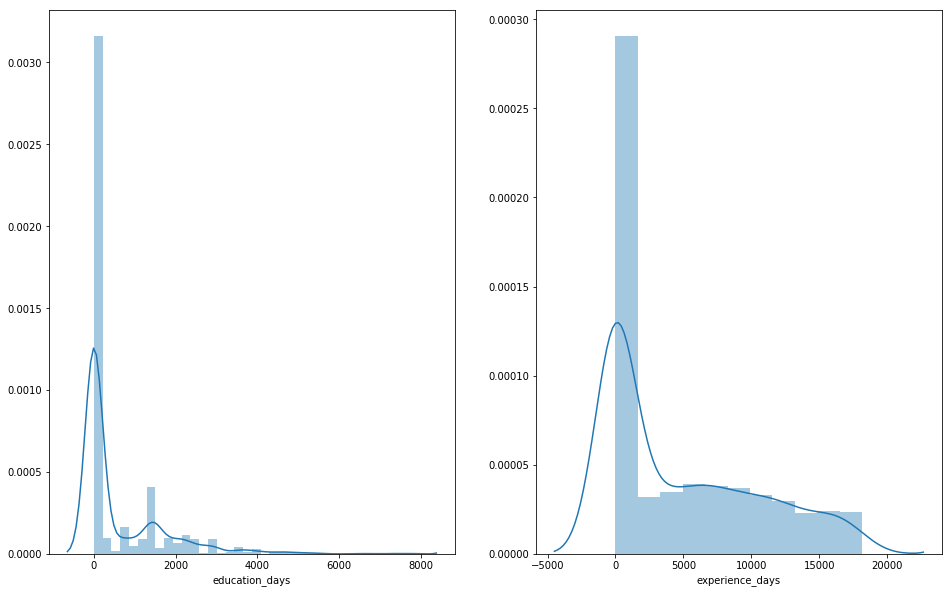

In [25]:
#Univariate Data Analysis
fig, axes = plt.subplots(1, 2, figsize = (16,10) )
sns.distplot(df_train['education_days'], ax = axes[0])
sns.distplot(df_train['experience_days'], ax = axes[1])
# sns.distplot(df_train['education_days'], fit=norm, ax = axes[0])
# sns.distplot(df_train['experience_days'], fit=norm, ax = axes[1])

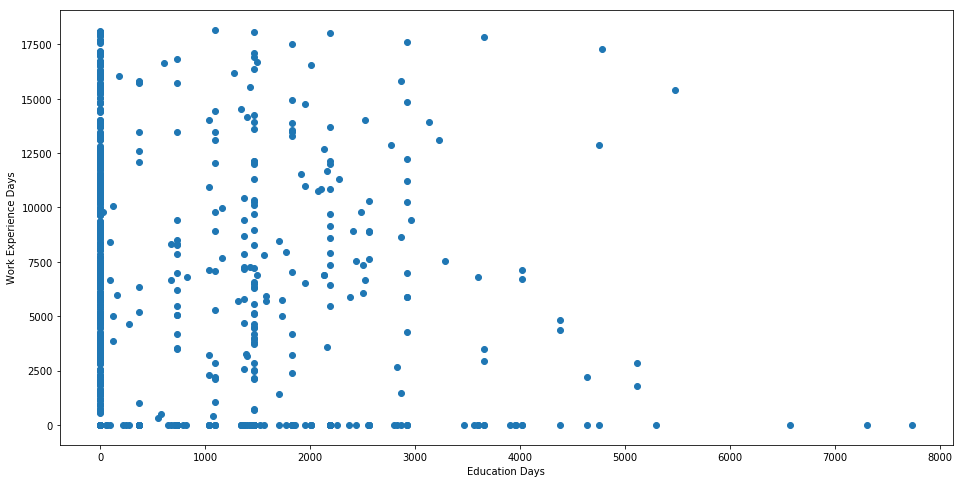

In [26]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df_train['education_days'], df_train['experience_days'])
ax.set_xlabel('Education Days')
ax.set_ylabel('Work Experience Days')
plt.show()

In [27]:
train_df = df_train.copy()
test_df = df_test.copy()

In [28]:
# further cleaning data

drop_exp_list = []
for idx, e in enumerate(train_df['experience_days']):
    if e == -1:
        drop_exp_list.append(idx)
#         print(idx, edu)
        
print(len(drop_exp_list))
    
train_df = train_df.drop(drop_exp_list)

339


In [29]:
# further cleaning data

drop_edu_list = []
for idx, e in enumerate(train_df['education_days']):
    if e == -1:
        drop_edu_list.append(idx)
        
print(len(drop_edu_list))
    
train_df = train_df.drop(drop_edu_list)

0


In [30]:
train_df.describe(include = ['number'])

,education_days,experience_days
count,661.000000,661.000000
mean,561.680787,7291.865356
std,1010.079454,5478.106022
min,0.000000,0.000000
25%,0.000000,2522.000000
50%,0.000000,6910.000000
75%,1095.000000,11599.000000
max,5479.000000,18174.000000


In [31]:
train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661 entries, 1 to 999
Data columns (total 5 columns):
education          661 non-null object
experience         661 non-null object
seniority_level    655 non-null object
education_days     661 non-null int64
experience_days    661 non-null int64
dtypes: int64(2), object(3)
memory usage: 31.0+ KB


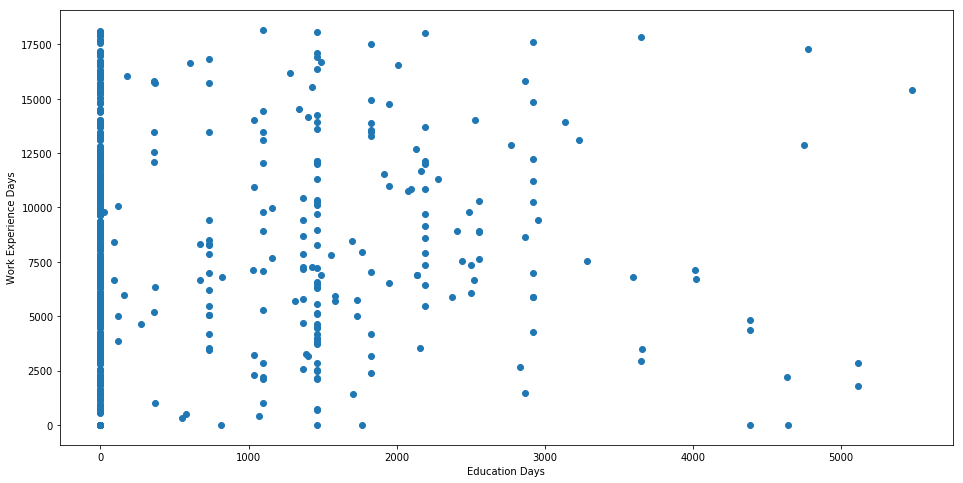

In [32]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(train_df['education_days'], train_df['experience_days'])
ax.set_xlabel('Education Days')
ax.set_ylabel('Work Experience Days')
plt.show()

In [33]:
# X = train_df[['education_days']]
# # Y = train_df['experience_days']
# Y = pd.factorize(train_df['experience_days'])[0].reshape(-1, 1) 

# # y.shape should be (N, 1)
# # y = mydata['label'] 
# # perform label encoding if "label" contains strings
# # y = pd.factorize(mydata['label'])[0].reshape(-1, 1) 
# # exampe: https://stackoverflow.com/questions/46638641/how-to-fix-valueerror-expected-2d-array-got-1d-array-instead-in-sklearn-pyth

In [34]:
X = train_df[['education_days', 'experience_days']]
# Y = train_df['experience_days']
Y = pd.factorize(train_df['seniority_level'])[0].reshape(-1, 1) 


In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=3)
print("Train features & target")
print(X_train.shape, Y_train.shape)
print("Test features & target")
print(X_test.shape, Y_test.shape)

Train features & target
(528, 2) (528, 1)
Test features & target
(133, 2) (133, 1)


In [36]:
# Y_test

In [37]:
# Decision Tree with k-fold (k=10)
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

grid_search = GridSearchCV(decision_tree_classifier, param_grid = parameter_grid, cv = 10)

grid_search.fit(X_train, Y_train)

print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

/Users/jefferyyu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Best Score: 0.4943181818181818
Best params: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}


/Users/jefferyyu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
best_est = grid_search.best_estimator_
clf = best_est.fit(X_train, Y_train)

# Decision Tree with k-fold (k=10)
# test the retuned best parameters
print("-- Testing best parameters [Grid]...")
# scores = cross_val_score(best_est, X_train, Y_train, cv=5)

scores = cross_val_score(best_est, X_test, Y_test, cv=5)
# scores.sort()
print("Scores: ", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))


-- Testing best parameters [Grid]...
Scores:  [0.51724138 0.48148148 0.33333333 0.40740741 0.34782609]
Mean: 0.4174579376978178
Standard Deviation: 0.07222507353394239
Accuracy: 0.417 (+/- 0.144)


/Users/jefferyyu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [42]:
# Decision Tree for held-out testing data
decision_tree = DecisionTreeClassifier()
clf = decision_tree.fit(X_train, Y_train)
decision_tree.score(X_test, Y_test)

0.37593984962406013